# Upgrade Pandas

In [1]:
!pip install pandas==1.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4


# Imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import time
import random
import logging
import os.path
import matplotlib.pyplot as plt
import json
import seaborn as sn
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
with open('../data/casp13/casp13_data.json') as json_file:
    casp13_dict = json.load(json_file)

# Functions

## Helpers

In [4]:
def save_model_history(model, encoding, k):
    with open(f'drive/My Drive/University of Glasgow/L4/L4 Project/models/trained/BiLSTM_{encoding}_fold{k}_hist.txt', 'w') as f:
        f.write("mcc:" + '\n')
        for elt in model.mcc_history:
            f.write(str(elt) + '\n')

        f.write("loss:" + '\n')
        for elt in model.loss_history:
            f.write(str(elt) + '\n')

In [5]:
def is_disc(chain):
	domains = casp13_dict['domains'][chain]
	for _, bounds in domains.items():
		if ';' in bounds:
			return True
	return False

def boundaries_to_domains(binary_vector):
    binary_vector = np.copy(binary_vector)
    domain = 1
    for i in range(len(binary_vector)):
        if int(binary_vector[i]) == 1:
            # this is the start of a new domain
            domain += 1
        binary_vector[i] = domain
    return binary_vector.astype(int)

def ndo_score(y_pred, y_true, key):
    if is_disc(key):
        return 'n/a'

    y_pred = boundaries_to_domains(y_pred)
    y_true = boundaries_to_domains(y_true)

    table = np.zeros((max(y_pred)+2,max(y_true)+2))
    
    for d_pred, d_true in zip(y_pred, y_true):
        table[d_pred, d_true] += 1

    # columns
    for i in range(1, table.shape[1]-1):
        table[-1, i] = 2 * max(table[:, i]) - sum(table[:, i])

    # rows
    for i in range(1, table.shape[0]-1):
        table[i, -1] = 2 * max(table[i, :]) - sum(table[i, :])

    table[-1, -1] = (sum(table[:, -1]) + sum(table[-1, :])) / 2


    num_of_defined_domains = 0
    for elt in y_true:
        if elt > 0:
            num_of_defined_domains += 1
    score = table[-1, -1] / num_of_defined_domains

    return score



def plot_losses(losses):
    x_label = "Steps"
    y_label = "Running loss"

    # Plot the losses
    plt.figure(figsize=(8, 6), dpi=80)
    plt.title("Running loss over time")
    plt.plot(losses)

    # Add x and y labels to the plot
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()


def update_dict(data, code, chain, domain, boundaries):
    data[code] = data.get(code, {})
    if chain not in data[code].keys():
        data[code][chain] = {}
    data[code][chain][str(int(domain))] = boundaries
    return data


def num_of_domains(key):
    return len(casp13_dict['domains'][key])


def get_cath(lines_range = None, file="../data/cath/cath_domain_boundaries.txt", verb=False):
    with open(file, "r") as f:
        lines = f.readlines() if lines_range is None else f.readlines()[lines_range[0]:lines_range[1]]
        lines = map(lambda x : x.strip(), lines)
        big = 0
        data = {}
        for line in lines:
            name, boundaries = line.split("\t")
            code = name[:4]
            chain = name[4]
            domain = name[5:]
            data = update_dict(data, code, chain, domain, boundaries)
    # verb and pprint(data)
    return data

def load_data(path, encoding):
    encoding_file = encoding_map[encoding]
    data = pd.read_pickle(path + encoding_file)
    return data


def median_seq(seq, logits):
    # parse a sequence (which will be the output from the model)
    # for every series of consecutive ones, leave only the median as one - the rest turn to 0
    # seq = [1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1]
    new_seq = np.zeros(len(seq))
    consecutive_ones_indices = []
    medians = []

    # marks if the first consecutive zeros that are less than the typical size is the first (meaning is the beginning of the first domain)
    for i in range(len(seq)):
        if seq[i] == 0:
            if len(consecutive_ones_indices) > 0:
                h = [logits[elt] for elt in consecutive_ones_indices]
                point = consecutive_ones_indices[np.argmax(h)]
                medians.append(point)
            consecutive_ones_indices = []

        if seq[i] == 1:
            consecutive_ones_indices.append(i)

    if len(consecutive_ones_indices) > 0:
        h = [logits[elt] for elt in consecutive_ones_indices]
        point = consecutive_ones_indices[np.argmax(h)]
        medians.append(point)

    for elt in medians:
        new_seq[elt] = 1

    return new_seq

def amplify_sharp(arr, size=41):
    conv = np.ones((size))
    result = np.convolve(arr, conv, mode='same')
    normalize_by = np.max(result)
    result = result / max(normalize_by, 1)
    return result 

## Metrics

In [6]:
def confusion_matrix_B(all_y_pred, all_y_true, t, margin=20):
    ts, tm, fs, fm = 0, 0, 0, 0
    for (y_pred, y_true) in zip(all_y_pred, all_y_true):
        y_true = np.copy(y_true)
        y_pred = np.copy(median_seq(np.where(y_pred > t, 1, 0), y_pred))
        
        # for i in range(len(y_pred)):
        #     window = y_true[max(0, i-margin):min(len(y_true), i+margin+1)]
        #     indices_window = list(range(max(0, i-margin), min(len(y_true), i+margin+1)))
        #     if y_pred[i] == 1.0:
        #         if 1.0 in window:
        #             pos = np.where(window == 1.0)[0][0]
        #             j = indices_window[pos]
        #             y_true[j] = 0.0
        #         else:
        #             y_pred[i] = 0.0

        true_num = np.sum(y_true)
        pred_num = np.sum(y_pred)
        if int(true_num) == 0 and int(pred_num) == 0:
            ts += 1
        
        if int(true_num) > 0 and int(pred_num) > 0:
            tm += 1

        if int(true_num) == 0 and int(pred_num) > 0:
            fm += 1

        if int(true_num) > 0 and int(pred_num) == 0:
            fs += 1
    return (ts, tm, fs, fm)

In [7]:
# mcc optmization
# def confusion_matrix_B(all_y_pred, all_y_true, t):
#     ts, tm, fs, fm = 0, 0, 0, 0
#     for (pred, true) in zip(all_y_pred, all_y_true):
#         pred = np.where(pred > t, 1, 0)
#         pred = median_seq(pred)
#         true_num = np.sum(true)
#         pred_num = np.sum(pred)
#         if int(true_num) == 0 and int(pred_num) == 0:
#             ts += 1
        
#         if int(true_num) > 0 and int(pred_num) > 0:
#             tm += 1

#         if int(true_num) == 0 and int(pred_num) > 0:
#             fm += 1

#         if int(true_num) > 0 and int(pred_num) == 0:
#             fs += 1
#     return (ts, tm, fs, fm)

def mcc_single_multi(ts, tm, fs, fm):
    mcc_num = (tm * ts) - (fm * fs)
    mcc_den = ((tm + fm) * (tm + fs) * (fm + ts) * (ts + fs))**0.5
    mcc = mcc_num / mcc_den if mcc_den != 0 else 0
    return mcc

def optimise_single_multi_mcc(all_y_pred, all_y_true, max_num_iterations=10, linspace_size=16, start=0, end=1, ):
    best_score = 0
    i = 0
    flag = True
    pairs = []
    while max_num_iterations > i and flag:
        flag = False
        for t in np.linspace(start, end, linspace_size):
            ts, tm, fs, fm = confusion_matrix_B(all_y_pred, all_y_true, t)
            ps, rs, pm, rm, acc, mcc = num_of_domains_metrics((ts, tm, fs, fm))
            score = mcc
            # score = mcc_single_multi(ts, tm, fs, fm)
            pairs.append((ps, rs, pm, rm, acc, mcc, t))
            if score > best_score:
                best_t = t
                best_score = score
                flag = True
        start = best_t * 0.7
        end = best_t * 1.3
        i += 1
        linspace_size += 2
    return best_score, best_t, pairs

In [8]:
def dbd_score(y_pred, y_true, margin=20):
    """A variation of DBD above that instead of finding a 1 in the window
        we find the closest one. We expect this would increase the mean dbd"""
    scores = []
    number_of_true_boundaries = np.sum(y_true)
    number_of_pred_boundaries = np.sum(y_pred)
    denominator = max(number_of_true_boundaries,number_of_pred_boundaries)

    if denominator == 0:
        return 'n/a'

    y_true_cp = np.copy(y_true)
    for i in range(len(y_pred)):
        window = y_true_cp[max(0, i-margin):min(len(y_true_cp), i+margin+1)]
        indices_window = list(range(max(0, i-margin), min(len(y_true_cp), i+margin+1)))
        if y_pred[i] == 1.0:
            if 1.0 in window:
                positions_with_boundaries = np.argwhere(window == 1).flatten()
                js = [indices_window[pos] for pos in positions_with_boundaries]
                closest_j = js[0]
                for j in js:
                    if abs(j - i) < abs(closest_j - i):
                        closest_j = j
                diff = abs(i - closest_j)
                score = ((margin - diff) + 1) / (margin + 1)
                y_true_cp[closest_j] = 0
                scores.append(score)
    return np.sum(scores) / denominator


def confusion_matrix_bp(y_pred, y_true, margin):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    y_true_cp = np.copy(y_true)

    for i in range(len(y_pred)):
        window = y_true_cp[max(0, i-margin):min(len(y_true_cp), i+margin+1)]
        indices_window = list(range(max(0, i-margin), min(len(y_true_cp), i+margin+1)))
        if y_pred[i] == 1.0:
            if 1.0 in window:
                pos = np.where(window == 1.0)[0][0]
                j = indices_window[pos]
                y_true_cp[j] = 0.0
                tp += 1
            else:
                fp += 1

    for i in range(len(y_pred)):
        if y_pred[i] == 0.0:
            if  y_true_cp[i] == 1.0:
                fn += 1
            else:
                tn += 1

    return (tp, tn, fp, fn)


def num_of_domains_metrics(confusion_matrix_num):
    ts, tm, fs, fm = confusion_matrix_num
    # single
    pre_single = ts / (ts + fs) if (ts + fs) != 0 else 0
    rec_single = ts / (ts + fm) if (ts + fm) != 0 else 0
    
    # multi
    pre_multi = tm / (tm + fm) if (tm + fm) != 0 else 0
    rec_multi = tm / (tm + fs) if (tm + fs) != 0 else 0

    acc = (tm + ts) / (tm + ts + fm + fs)

    # mcc
    mcc_num = (tm * ts) - (fm * fs)
    mcc_den = ((tm + fm) * (tm + fs) * (fm + ts) * (ts + fs))**0.5
    mcc = mcc_num / mcc_den if mcc_den != 0 else 0

    return (pre_single, rec_single, pre_multi, rec_multi, acc, mcc)

def boundary_prediction_metrics(y_pred, y_true, key, margin=20):
    tp, tn, fp, fn = confusion_matrix_bp(y_pred, y_true, margin)

    mcc_num = (tp * tn) - (fp * fn)
    mcc_den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_num / mcc_den if mcc_den else 0

    dbd = dbd_score(y_pred, y_true, 8)
    ndo = ndo_score(y_pred, y_true, key)

    return (ndo, dbd, mcc)

def domain_number_metrics(all_y_pred, all_y_true, t):
    ts, tm, fs, fm = confusion_matrix_B(all_y_pred, all_y_true, t)
    pre_single, rec_single, pre_multi, rec_multi, acc, mcc = num_of_domains_metrics((ts, tm, fs, fm))
    return pre_single, rec_single, pre_multi, rec_multi, acc, mcc

## Train

In [9]:
def save_for_cutoff_optimisation(model, validation_loader):
    all_y_true = None
    all_y_pred = None
    n_samples = len(validation_loader)
    model.eval()
    with torch.no_grad():
        for i, (input, y_true, _, key, _) in enumerate(validation_loader):
            input = input.float().to(device)
            y_pred = model(input)

            y_pred = y_pred.cpu()
            y_true = y_true.cpu().detach().numpy()

            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)
    
            if  (all_y_true is None) and (all_y_pred is None):
                all_y_true = y_true
                all_y_pred = y_pred
            else:
                all_y_true = np.vstack((all_y_true, y_true))
                all_y_pred = np.vstack((all_y_pred, y_pred))
    model.train()
    return all_y_pred, all_y_true


def get_best_mcc(model, validation_loader):
    all_y_pred, all_y_true = save_for_cutoff_optimisation(model, validation_loader)
    best_score, best_t, pairs = optimise_single_multi_mcc(all_y_pred, all_y_true)
    return best_score, best_t, pairs

In [10]:

def train(model, optimizer, scheduler, train_loader, num_epochs, validation_loader):
    n_total_steps = len(train_loader)
    print("Starting Training")
    model.train()
    for epoch in range(num_epochs):
        all_y_true = None
        all_y_pred = None
        running_loss = []
        validation_loss = []
        for i, (x, y_true, y_amplified, _, _) in enumerate(train_loader):
            x = x.to(device).float()
            y_true = y_true.reshape(-1)
            y_amplified = y_amplified.to(device).float().reshape(-1)
            y_pred = model(x).reshape(-1)
            loss = criterion(y_pred, y_amplified)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())

            if (i+1) % 10 == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{n_total_steps}], Running Loss: {np.mean(running_loss):.4f}')
                model.loss_history.append(np.mean(running_loss))
                running_loss = []

        model.eval()
        with torch.no_grad():
            for i, (x, y_true, y_amplified, _, seq_len) in enumerate(validation_loader):
                seq_len = seq_len.to(device)
                x = x.to(device).float()
                y_amplified = y_amplified.to(device).float().reshape(-1)
                y_pred = model(x).reshape(-1).float().to(device)
                loss = criterion(y_pred, y_amplified)
                validation_loss.append(loss.item())

                if (i+1) % 2 == 0:
                    print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{len(validation_loader)}], Running (Val) Loss: {np.mean(validation_loss):.4f}')
                    model.validation_loss_history.append(np.mean(validation_loss))
                    validation_loss = []    

            print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{len(validation_loader)}], Running (Val) Loss: {np.mean(validation_loss):.4f}')
            model.validation_loss_history.append(np.mean(validation_loss))

        print(f'Epoch: [{epoch+1}/{num_epochs}], Training Loss: {np.mean(running_loss):.4f}, Validation Loss: {np.mean(validation_loss):.4f}')
        scheduler.step()
        
    print(f'Finished training')

    return model

## Test

In [11]:
def test(model, validation_loader):
    n_samples = len(validation_loader)
    # mcc_single_multi, threshold = model.mcc_history[-1]
    best_score, threshold, _ = get_best_mcc(model, casp_loader)
    scores = {}
    all_y_pred, all_y_true = None, None
    print("Starting Testing")
    model.eval()
    with torch.no_grad():
        for i, (input, y_true, _, key, seq_len) in enumerate(validation_loader):
            input = input.float().to(device)
            y_pred = model(input)

            y_pred = y_pred.cpu()
            y_true = y_true.cpu().detach().numpy()

            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)

            logits = np.copy(y_pred.float().cpu().detach().numpy())
            y_pred = (y_pred > threshold).float().cpu().detach().numpy()
            y_pred = median_seq(y_pred, logits)


            if  (all_y_true is None) and (all_y_pred is None):
                all_y_true = y_true
                all_y_pred = y_pred
            else:
                all_y_true = np.vstack((all_y_true, y_true))
                all_y_pred = np.vstack((all_y_pred, y_pred))

            # undo padding
            y_true = y_true[:seq_len]
            y_pred = y_pred[:seq_len]

            key = key[0] # this is a tuple before indexing the first element which is a string
            number_of_domains = num_of_domains(key)
            category = str(number_of_domains)

            ndo, dbd, mcc_bp = boundary_prediction_metrics(y_pred, y_true, key)
            if not scores.get(category):
                scores[category] = {'boundary_prediction' : []}
            scores[category]['boundary_prediction'].append((ndo, dbd, mcc_bp))
            
            if (i+1) % 150 == 0:
                print(f'Step: [{i+1}/{n_samples}]')

        ps, rs, pm, rm, acc, mcc_sm = domain_number_metrics(all_y_pred, all_y_true, threshold)
        scores['domain_number'] = (ps, pm, rs, rm, acc, mcc_sm)


    model.train()

    print("Finished Testing")
    return scores

In [12]:
def test_number_of_domains_predicted(model, validation_loader, threshold):
    n_samples = len(validation_loader)
    confusion_matrix = np.zeros((12,12))
    model.eval()
    coords = []
    with torch.no_grad():
        for i, (input, y_true, _, key, seq_len) in enumerate(validation_loader):
            input = input.float().to(device)
            y_pred = model(input)

            y_pred = y_pred.cpu()
            y_true = y_true.cpu().detach().numpy()

            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)

            y_pred = median_seq((y_pred > threshold).float().cpu().detach().numpy(),y_pred)
            # y_pred = median_seq(y_pred)

            predicted_number = int(np.sum(y_pred))
            true_number = int(np.sum(y_true))
            coords.append((predicted_number, true_number))
            
            confusion_matrix[predicted_number, true_number] += 1

    return confusion_matrix


def single_multi_cf(model, validation_loader, threshold):
    n_samples = len(validation_loader)
    confusion_matrix = np.zeros((2,2))
    model.eval()
    with torch.no_grad():
        for i, (input, y_true, _, key, seq_len) in enumerate(validation_loader):
            input = input.float().to(device)
            y_pred = model(input)

            y_pred = y_pred.cpu()
            y_true = y_true.cpu().detach().numpy()

            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)

            y_pred = median_seq((y_pred > threshold).float().cpu().detach().numpy(),y_pred)

            prediction = min(int(np.sum(y_pred)), 1)

            truth = min(int(np.sum(y_true)), 1)
            
            confusion_matrix[prediction, truth] += 1

    return confusion_matrix


def domain_number_sequence_length(model, validation_loader, threshold):
    n_samples = len(validation_loader)
    predictions = []
    truths = []
    model.eval()
    with torch.no_grad():
        for i, (input, y_true, _, key, seq_len) in enumerate(validation_loader):
            input = input.float().to(device)
            y_pred = model(input)

            y_pred = y_pred.cpu()
            y_true = y_true.cpu().detach().numpy()

            y_pred = y_pred.reshape(-1)
            y_true = y_true.reshape(-1)

            y_pred = median_seq((y_pred > threshold).float().cpu().detach().numpy(),y_pred)

            prediction = int(np.sum(y_pred))
            truth = int(np.sum(y_true))

            predictions.append((prediction, seq_len))
            truths.append((truth, seq_len))

    return predictions, truths


# Classes

In [13]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.0)
        # x -> batch_size, sequence_length, input_size
        self.fc0 = nn.Linear(hidden_size*2,80)
        self.fc1 = nn.Linear(80,60)
        self.fc2 = nn.Linear(60,50)
        self.fc3 = nn.Linear(50,20)
        self.fc4 = nn.Linear(20,10)
        self.fc5 = nn.Linear(10, 1)

        self.a = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.loss_history = []
        self.mcc_history = []
        self.validation_loss_history = []

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        # out: batch_size, seq_length, hidden_size

        out, _ = self.lstm(x, (h0, c0))
        out = self.a(out)

        out = self.fc0(out)
        out = self.a(out)

        out = self.fc1(out)
        out = self.a(out)

        out = self.fc2(out)
        out = self.a(out)

        out = self.fc3(out)
        out = self.a(out)

        out = self.fc4(out)
        out = self.a(out)

        out = self.fc5(out)
        out = self.sig(out)
        return out
        

class SequenceDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        chain_sizes = [data['in'].iloc[i].shape[0] for i in range(len(data))]
        self.longest_chain = max(chain_sizes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data['in'].iloc[index]
        y = self.data['out'].iloc[index]
        seq_len = self.data['seq_len'].iloc[index]

        x = np.pad(x, ((0, self.longest_chain-x.shape[0]), (0,0)), 'minimum')
        
        y = y.astype(np.float16) # convert from bool to float

        y_amplified = amplify_sharp(y, 41) 
        y_amplified = np.pad(y_amplified, (0, self.longest_chain-y_amplified.shape[0]), 'minimum')
        y = np.pad(y, (0, self.longest_chain-y.shape[0]), 'minimum')
        y_amplified = y_amplified.reshape((1,-1))
        y_amplified = np.array(y_amplified, dtype=np.float64)
        key = self.data['key'].iloc[index]

        return x, y, y_amplified, key, seq_len

# Main

## Hyperparams

In [19]:
cath = get_cath()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# three datasets with different encodings are available: CARP encodings, ESM encodings and One-Hot encodings:
# carp38M_data.csv
# esm35M_data.csv
# onehot_data.csv

encoding_map = {'carp' : 'carp38M_data.csv', 'esm' : 'esm35M_data.csv', 'onehot' : 'onehot_data.csv'}
input_size_map = {'carp' : 1024, 'esm' : 480, 'onehot' : 21}


encoding = 'esm'
input_size = input_size_map[encoding]
num_layers = 3
hidden_size = 100
num_epochs = 10
batch_size = 32
learning_rate = 0.001
criterion = nn.BCELoss(reduction='sum')

## Load Data

In [15]:
casp_dataframe = pd.read_pickle('../data/casp13/casp13_test_model.csv')
casp_dataset = SequenceDataset(casp_dataframe, transforms.ToTensor())

In [16]:
# dataframe = load_data(path, encoding)
# dataset = SequenceDataset(dataframe, transforms.ToTensor())

In [17]:
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
casp_loader = DataLoader(casp_dataset, batch_size=1, shuffle=True)

## Main

In [18]:
# NO NEED TO TRAIN, SEE CELLS BELOW

# model = BiLSTM(input_size, hidden_size, num_layers).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.85)
# start = time.time()
# model = train(model, optimizer, scheduler, train_loader, num_epochs, casp_loader)
# end = time.time()
# print(f"Time to train: {end - start}")

In [ ]:
# torch.save(model.state_dict(), f"{trained_models_path}_CASP13_READY")

In [21]:
model = BiLSTM(input_size, hidden_size, num_layers).to(device)
model.load_state_dict(torch.load(f"../pre_trained_models/CASP13_READY", map_location=torch.device('cpu')))
model.eval()

BiLSTM(
  (lstm): LSTM(480, 100, num_layers=3, batch_first=True, bidirectional=True)
  (fc0): Linear(in_features=200, out_features=80, bias=True)
  (fc1): Linear(in_features=80, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
  (a): ReLU()
  (sig): Sigmoid()
)

best t: 0.30000000000000004

# Analysis

In [23]:
scores = test(model, casp_loader)
best_score, best_t, pairs = get_best_mcc(model, casp_loader)
confusion_matrix = test_number_of_domains_predicted(model, casp_loader, best_t)

Starting Testing
Finished Testing


<function matplotlib.pyplot.show(close=None, block=None)>

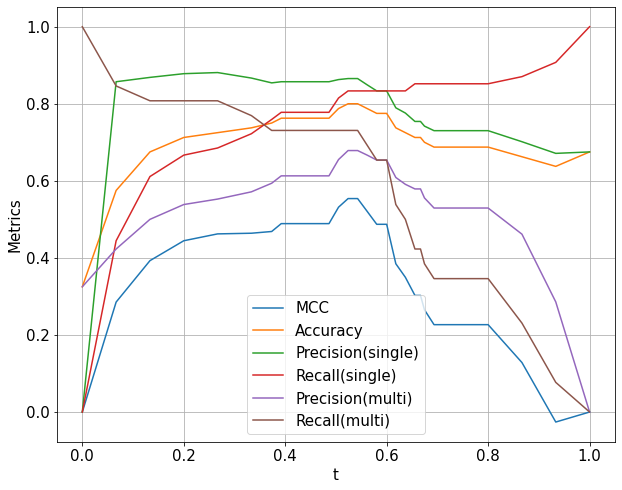

In [24]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

sorted_pairs = sorted(pairs, key=lambda x : x[6])

ps_score = [i[0] for i in sorted_pairs]
rs_score = [i[1] for i in sorted_pairs]
pm_score = [i[2] for i in sorted_pairs]
rm_score = [i[3] for i in sorted_pairs]
acc_score = [i[4] for i in sorted_pairs]
mcc_score = [i[5] for i in sorted_pairs]

ts = [i[6] for i in sorted_pairs]

fig = plt.figure(figsize=(10,8))
plt.xlabel("t")
plt.ylabel("Metrics")
plt.grid()

plt.plot(ts, mcc_score, label='MCC')
plt.plot(ts, acc_score, label='Accuracy')
plt.plot(ts, ps_score, label='Precision(single)')
plt.plot(ts, rs_score, label='Recall(single)')
plt.plot(ts, pm_score, label='Precision(multi)')
plt.plot(ts, rm_score, label='Recall(multi)')

plt.legend()
plt.savefig('t_optimisation.pdf')  

plt.show

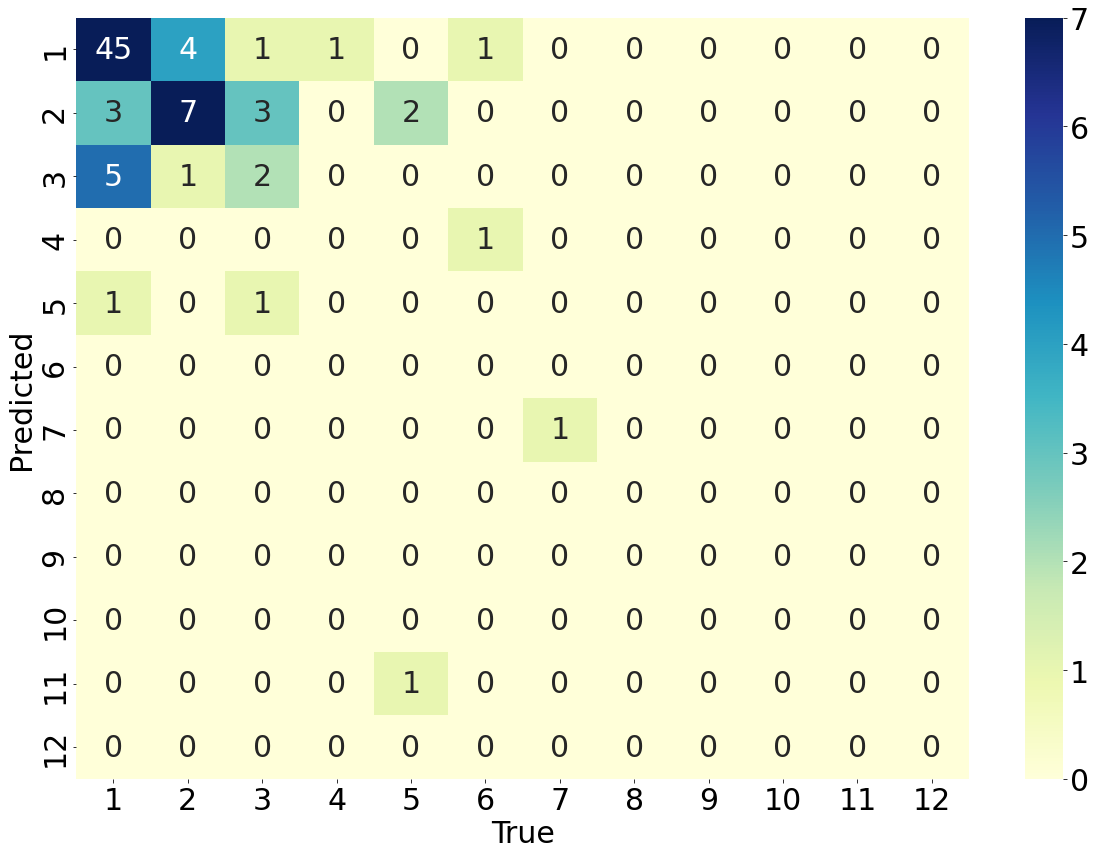

In [25]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)
single_mutli_cf = single_multi_cf(model, casp_loader, best_t)
df_cm = pd.DataFrame(confusion_matrix, index = [str(i+1) for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]],
                  columns = [str(i+1) for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", vmin=0, vmax=7)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.savefig('casp13heatmap.pdf')
plt.show()

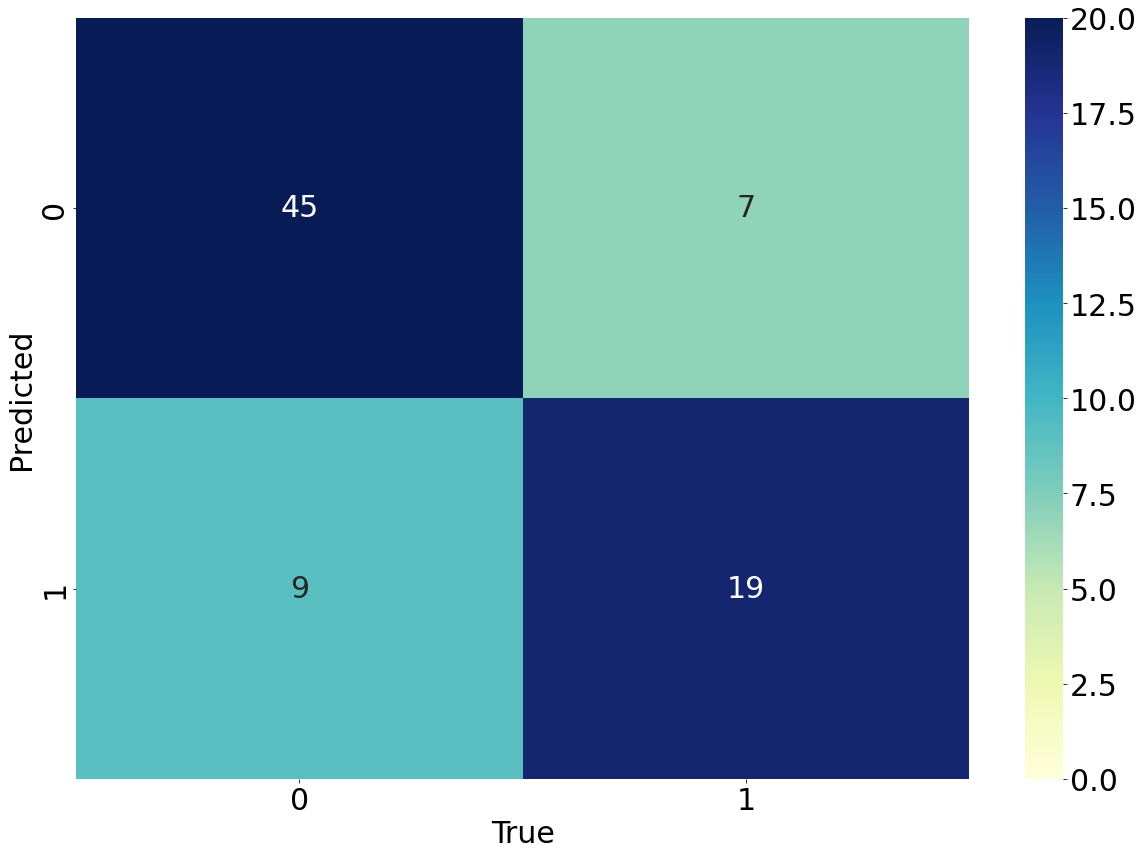

In [26]:
df_cm = pd.DataFrame(single_mutli_cf, index = [str(i) for i in [0, 1]],
                  columns = [str(i) for i in [0, 1]])
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", vmin=0, vmax=20)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.savefig('casp13heatmap_sm.pdf')

plt.show()

In [27]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [28]:
counter = 0
ndo, dbd, mcc_bp = ([],[],[])
for n in scores.keys():
    if n == 'domain_number':
        continue
    for tpl in scores[n]['boundary_prediction']:
        ndo_, dbd_, mcc_bp_ = tpl
        if ndo_ != 'n/a':
            ndo.append(ndo_)
        if dbd_ != 'n/a':
            dbd.append(dbd_)
        mcc_bp.append(mcc_bp_)
        
# print(np.mean(ndo))
print("Mean DBD:")
print(np.mean(dbd))
# print(np.mean(mcc_bp))

# 0.8060918979142484 0.5395412457912456 0.155408166359137

Mean DBD:
0.12423280423280424


In [29]:
print("Precision(single), Recall(single), Precision(multi), Recall(multi), Accuracy, MCC:")
print(scores['domain_number'])

Precision(single), Recall(single), Precision(multi), Recall(multi), Accuracy, MCC:
(0.8653846153846154, 0.6785714285714286, 0.8333333333333334, 0.7307692307692307, 0.8, 0.5539377213682883)


In [30]:
predictions, truths = domain_number_sequence_length(model, casp_loader, best_t)

In [31]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

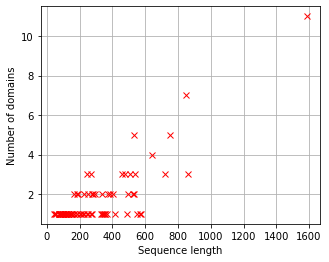

Correlation coefficient
0.8141802672734249


In [32]:
fig = plt.figure(figsize=(5,4))

x_axis = [x[1].item() for x in predictions]
y_axis = [x[0] + 1 for x in predictions]

plt.grid()
plt.xlabel("Sequence length")
plt.ylabel("Number of domains")
plt.plot(x_axis, y_axis, 'x', color='red')
plt.savefig('length_vs_number_pred.pdf')

plt.show()

correlation_coef = np.corrcoef(np.array(x_axis), np.array(y_axis))[0, 1]
print("Correlation coefficient")
print(correlation_coef)

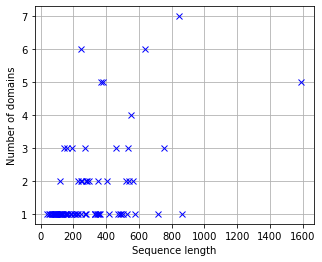

Correlation coefficient
0.4908461943625021


In [33]:
fig = plt.figure(figsize=(5,4))

x_axis = [x[1].item() for x in truths]
y_axis = [x[0] + 1 for x in truths]
plt.grid()
plt.xlabel("Sequence length")
plt.ylabel("Number of domains")
plt.plot(x_axis, y_axis, 'x', color='blue')
plt.savefig('length_vs_number_truth.pdf')
plt.show()

correlation_coef = np.corrcoef(np.array(x_axis), np.array(y_axis))[0, 1]
print("Correlation coefficient")
print(correlation_coef)